<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [83]:
#@title Current Date
Today = '2021-10-05' #@param {type:"date"}


#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "6" #@param {type:"string"}
Student_ID&Name = "9309888_JohnHayes" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
#@markdown ---

In [84]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

Your introduction here.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [85]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [86]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [88]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [89]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# for plots etc
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

# For NLP
import spacy as sp
from spacy import displacy

# For feature importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor

from imblearn.combine import SMOTETomek

import datetime

In [90]:
!pip install gpy

Defaulting to user installation because normal site-packages is not writeable


In [91]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

#### Any functions used later on

In [126]:
#--------------------------------------------------------------------------------
def nlk_nlp_preprocess(text_feat,
                       stop_words,
                       df_data,
                       min_word_len):
    """
    Preprocessing training and test features
    """
    
    #print("Columns {}".format(df_data.columns))
    #print("Features '{}'".format(text_feat))
    for feat in text_feat:
        
        #print("Using feature '{}'".format(feat))
        data_list = df_data[feat].tolist()
        tmp_df = pd.DataFrame({feat:data_list})
        
        # Removing numbers and single letters from the dataset, except for what is     
        tmp_df[feat] = tmp_df[feat].str.replace("[^a-zA-Z#]", " ")
    
        # Removing single letters
        tmp_df[feat] = tmp_df[feat].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
        
        # Remove short words
        tmp_df[feat] = tmp_df[feat].apply(lambda x: ' '.join([w for w in x.split() if len(w)>min_word_len]))
    
        # Make all text lower case
        tmp_df[feat] = tmp_df[feat].apply(lambda x: x.lower())
    
        # Tokenisation
        tokenised_doc = tmp_df[feat].apply(lambda x: x.split())

        # remove stop-words
        tokenised_doc = tokenised_doc.apply(lambda x: [item for item in x if item not in stop_words])
        
        print("Len of feat {}".format(len(df_data[feat])))
        
        
        # de-tokenization
        detokenised_doc = []
        for i in range(len(df_data[feat])):
            t = ' '.join(tokenised_doc[i])
            detokenised_doc.append(t)

        # Replace feature with the de-tokenised text
        #print("Idx {} Len of detok {}".format(i, len(detokenised_doc)))
        df_data[feat] = detokenised_doc
        
        data_list = []
        
    #print("at the end Columns {}".format(df_data.columns))
    return df_data

#--------------------------------------------------------------------------------
def nlp_preprocess1():
    """
    Convert a collection of raw documents to a matrix of TF-IDF features.
    """
    return

def run_model(x_data, y_data, iterations, sample_size, text=None):
    """
    Execute the model for a given data set
    """
    
    if text != None:
        print(text)
    
    with pm.Model() as model:
        
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
  
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=x_data.shape[1])
  
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
  
        # linear regression relationship
        # linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, x_data.T)
        
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_data[:,0])
        
    with model:
        
        # iterations of the algorithm
        approximation = pm.fit(iterations,method='advi')

    # samples from the posterior   
    posterior = approximation.sample(sample_size)
    
    return posterior, approximation


#--------------------------------------------------------------------------------
def ppc(alpha, beta, sigma, X, nsamples=500):
    """
    Posterior predictive checks (PPCs)
    """
    
    # Select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        
        # we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T + \
                                    np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
        
    return Ypred


#--------------------------------------------------------------------------------
def train_cluster(x_train, x_test, clust_num):
    """
    Train the cluster
    """
    
    Xn = x_train[clusters_train==clust_num,:]
    Xtestn = x_test[clusters_test==clust_num,:]

    ylog = np.log(ys_train.astype('float')[clusters_train==clust_num,:])
    yscaler = StandardScaler().fit(ylog)
    yn = yscaler.transform(ylog)
    
    return ylog, yscaler, Xn, yn, Xtestn, yscaler


#--------------------------------------------------------------------------------
def plot_redictions(y_pred, ylog, title=None):
    
    plt.figure(figsize=(9,8))
    for i in range(y_pred.shape[0]):
        az.plot_dist( y_pred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
        
    az.plot_dist(y_pred[i,:],color='r',
                 plot_kwargs={"linewidth": 0.2},
                 label="prediction")
    
    az.plot_dist(ylog, label='true observations');
    if title != None:
        plt.title(title)
        
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");


#--------------------------------------------------------------------------------
def cluster_sim(posterior, Xn, ylog, title=None, num_samples=200):
    """
    Display a prediction for a single cluster
    """
    
    # Simulation
    Ypred = yscaler.inverse_transform(ppc(posterior['alpha'],
                                            posterior['beta'],
                                            posterior['sigma_n'],
                                            Xn,
                                            nsamples=num_samples))
    plot_redictions(Ypred, ylog, title)
    

#--------------------------------------------------------------------------------
def create_heat_map(data):
    """
    Create a correlation matrix
    """
    
    # Plot the heatmap. The numbers are easier to read IMO
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            ax=ax)
    

In [93]:
print("Start time {}".format(datetime.datetime.now().time()))

Start time 18:32:47.657669


#### Some variables that will be used throughout

In [94]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

num_iter = 50000
sample_size = 5000
num_of_clust_samples = 200

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/johnh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

#### Load the data

In [95]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Etivity3-Data/'
    
else:
    Path = "./Data/"
    
# House price data from csv files
train_data = Path + 'HousePrice_Train.csv'
test_data = Path + 'HousePrice_Test.csv'

df_train_data = pd.read_csv(train_data)
print("Training data {}".format(df_train_data.shape))

# Test data
df_test_data = pd.read_csv(test_data)
print("Test data {}".format(df_test_data.shape))

Training data (1638, 14)
Test data (702, 13)


### Train dataset

In [96]:
# show first data frame rows 
df_train_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
0,1,12409116,Ongar,2,2,C3,DNG are delighted to present to the market no....,NaN,None,53.396659,-6.438791,apartment,67.00,195000
1,2,12320330,North Strand,1,2,D1,13 Northbrook Terrace is a charming red brick ...,NaN,Bight and Spacious interior\nNumerous original...,53.357129,-6.239779,terraced,95.97,425000
2,3,12405953,Stepaside,3,3,A3,"Welcome to No. 6 Cotter Close, an immaculately...",NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,semi-detached,107.00,535000
3,4,12202582,Cabinteely,1,3,E1,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,NaN,Wonderful 3 bed detached bungalow. \nAccom...,53.261600,-6.166738,detached,81.00,499000
4,5,12299336,Lusk,3,4,D1,'Four Seasons' comes to the market as a wonder...,NaN,Detached Property \nDouble Glazed Windows...,53.550731,-6.121415,detached,153.00,510000


In [97]:
# Generate descriptive statistics
df_train_data.describe(include='all')

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
count,1638.000000,1.638000e+03,1638,1638.000000,1638.000000,1387,1638,577,1638,1638.000000,1638.000000,1638,1638.000000,1.638000e+03
unique,NaN,NaN,142,NaN,NaN,16,1638,31,1118,NaN,NaN,10,NaN,NaN
top,NaN,NaN,Castleknock,NaN,NaN,D1,DNG are delighted to present to the market no....,"Parking,Gas Fired Central Heating",None,NaN,NaN,semi-detached,NaN,NaN
freq,NaN,NaN,57,NaN,NaN,182,1,118,516,NaN,NaN,458,NaN,NaN
mean,819.500000,1.231930e+07,NaN,2.054335,3.043346,NaN,NaN,NaN,NaN,53.350473,-6.255086,NaN,169.540695,5.547196e+05
std,472.994186,1.447540e+05,NaN,1.241259,1.379650,NaN,NaN,NaN,NaN,0.076832,0.144430,NaN,1791.793934,5.652032e+05
min,1.000000,1.118567e+07,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,52.501856,-6.497000,NaN,3.400000,1.999500e+04
25%,410.250000,1.228104e+07,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,53.294261,-6.309613,NaN,73.000000,2.950000e+05
50%,819.500000,1.238055e+07,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,53.341386,-6.247780,NaN,97.050000,3.950000e+05
75%,1228.750000,1.240548e+07,NaN,3.000000,4.000000,NaN,NaN,NaN,NaN,53.382031,-6.193982,NaN,135.000000,5.950000e+05


So there are 1638 entries. Both `BER_class` and `Services` have less than that. The `Services` is missing a lot of entries.

In [98]:
# Check for missing values
df_train_data.isna().sum()

Index               0
ID                  0
Location            0
Num_Bathrooms       0
Num_Beds            0
BER_class         251
Description         0
Services         1061
Features            0
Latitude            0
Longitude           0
Type                0
Surface             0
Price               0
dtype: int64

Since `Services` is missing over 60% of entries and there is no reasonable way to fill in values for that feature, given what it is used for, I think it should be dropped from the evaluation.

In [99]:
df_train_data['BER_class'].value_counts()

D1                     182
D2                     173
C3                     154
C2                     144
C1                     133
E1                     110
G                      103
E2                     101
F                       89
B3                      78
B2                      48
A3                      37
SINo666of2006exempt     15
A2                      12
B1                       7
A1                       1
Name: BER_class, dtype: int64

In [100]:
df_train_data['Num_Beds'].value_counts()

3     558
2     464
4     348
1     114
5     107
6      29
7      11
9       2
15      2
8       2
27      1
Name: Num_Beds, dtype: int64

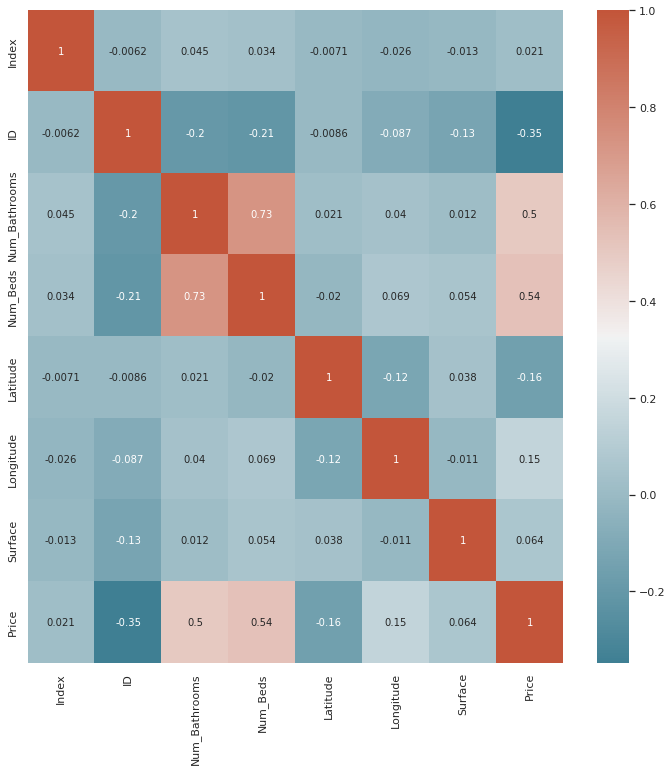

In [101]:
create_heat_map(df_train_data)

The above is showing little correlation between the various features, with the only significant ones being the number of `Num_Beds` and `Num_Bathrooms` related to `price`.

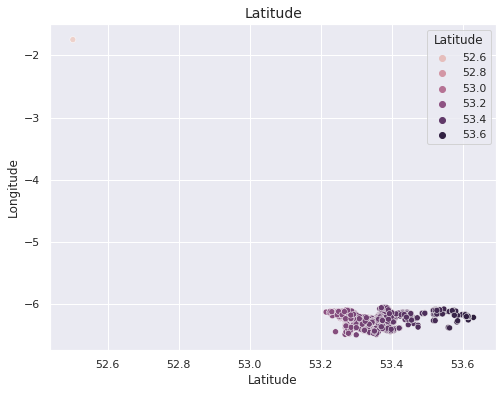

In [102]:
sns.set(rc={'figure.figsize':(8,6)})

sns.scatterplot(data=df_train_data,x='Latitude', y='Longitude', hue='Latitude')
plt.title("Latitude", fontsize=14)
plt.show()

The above is showing 1 outlier. It is in row 357 with lonitude of -1.744995 latitude of 52.5018563. This is showing as 34-12 Wheatfield Cl, Birmingham B36 0QP, UK, so I will drop this value.

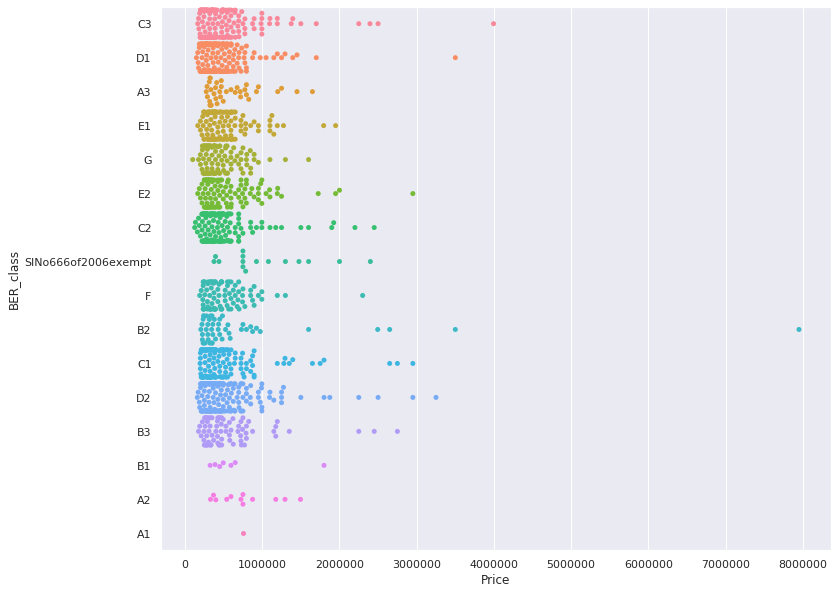

In [103]:
sns.set(rc={'figure.figsize':(12, 10)})
sns.swarmplot(data=df_train_data, x='Price', y='BER_class')
plt.show()

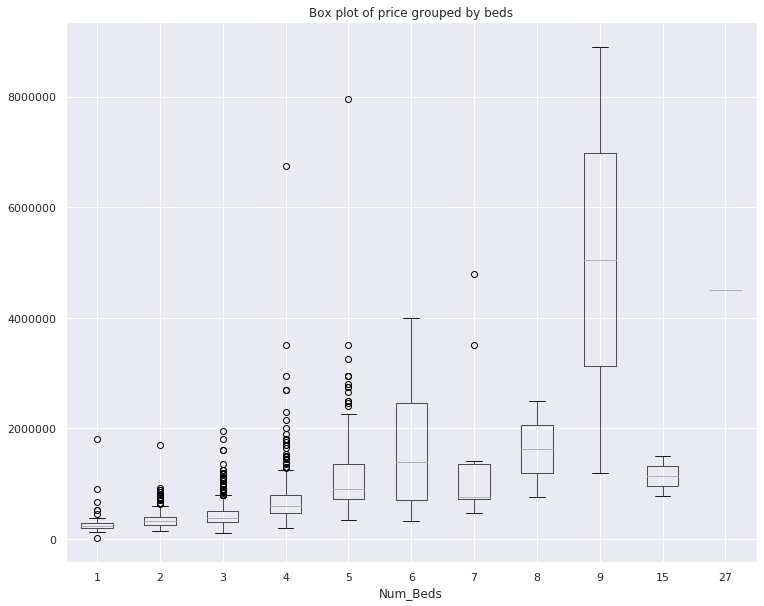

In [104]:
df_train_data.boxplot(column='Price', by='Num_Beds')
plt.title('Box plot of price grouped by beds')
plt.suptitle("")
plt.show()

In [105]:
# split data into training and test
#from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

In [106]:
# training dataset: 
#training_file = syntPath+filename1
# test dataset: 
#testing_file = syntPath+filename2
# cost dataset: 
#cost_file = syntPath+filename3

### Test dataset

In [107]:
# show first data frame rows 
df_test_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
0,1639,12292473,Milltown,2,2,C2,OMD Estate Agents are delighted to present thi...,"Parking,Oil Fired Central Heating",Designated parking spaces\nPresented in pristi...,53.316269,-6.243391,townhouse,65.0
1,1640,12314667,Glasnevin,2,5,E1,Welcome to Saint Anthony No.214 Glasnevin Aven...,"Parking,Gas Fired Central Heating",Modern Worcester Gas Boiler\nSingle Glazed Win...,53.390769,-6.281936,semi-detached,142.0
2,1641,11699240,Dalkey,1,2,G,"Located in this ever popular road, on grounds ...",NaN,2 BEDROOM DETACHED HOUSE ON 1/5th ACRE\nOIL F...,53.272486,-6.108675,detached,80.0
3,1642,12416984,Raheny,4,4,A2,DNG are delighted to represent the sale of thi...,"Parking,Alarm",Detached House\nSouth Facing Garden\nOff Stree...,53.376932,-6.185334,detached,209.0
4,1643,12383407,Crumlin,2,3,F,A unique opportunity to acquire this red brick...,"Parking,Gas Fired Central Heating,Alarm",Red brick end of terrace property \nC. 108sqm ...,53.327208,-6.308938,end-of-terrace,108.0


In [108]:
# Generate descriptive statistics
df_test_data.describe(include='all')

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
count,702.000000,7.020000e+02,702,702.000000,702.000000,594,702,246,702,702.000000,702.000000,702,702.000000
unique,NaN,NaN,129,NaN,NaN,15,702,27,506,NaN,NaN,9,NaN
top,NaN,NaN,Rathfarnham,NaN,NaN,D1,OMD Estate Agents are delighted to present thi...,"Parking,Gas Fired Central Heating",None,NaN,NaN,apartment,NaN
freq,NaN,NaN,28,NaN,NaN,72,1,51,197,NaN,NaN,194,NaN
mean,1989.500000,1.231545e+07,NaN,2.027066,2.987179,NaN,NaN,NaN,NaN,53.350445,-6.252411,NaN,132.603530
std,202.794231,1.420680e+05,NaN,1.071273,1.198480,NaN,NaN,NaN,NaN,0.073961,0.091600,NaN,330.347066
min,1639.000000,1.147889e+07,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,53.214227,-6.521183,NaN,32.100000
25%,1814.250000,1.227637e+07,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,53.295225,-6.304258,NaN,73.000000
50%,1989.500000,1.237928e+07,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,53.341153,-6.247799,NaN,99.200000
75%,2164.750000,1.240421e+07,NaN,3.000000,4.000000,NaN,NaN,NaN,NaN,53.381751,-6.184277,NaN,136.875000


In [109]:
# Check for missing values
df_test_data.isna().sum()

Index              0
ID                 0
Location           0
Num_Bathrooms      0
Num_Beds           0
BER_class        108
Description        0
Services         456
Features           0
Latitude           0
Longitude          0
Type               0
Surface            0
dtype: int64

As with the training data, since `Services` is missing over 50% of entries and there is no reasonable way to fill in values for that feature, given what it is used for, I think it should be dropped from the evaluation.

In [110]:
df_test_data['BER_class'].value_counts()

D1                     72
C3                     70
D2                     68
C2                     65
C1                     49
E2                     47
F                      46
E1                     44
G                      41
B3                     28
B2                     21
A3                     20
A2                      8
SINo666of2006exempt     8
B1                      7
Name: BER_class, dtype: int64

### Data Preparation <a id='data_preparation'></a>
* Remove anything with more than 6 beds and those that have no number specified.
* Remove anything with no `Num_Bathroom` value set.
* Remove `Services` since there are so many values missing.
* Remove the invalid long & lat entry.
* Apply some NLP examination to `Description`, `Features` and `Type` attributes.

In [111]:
df_train_clean = df_train_data.drop(columns=['Services', 'ID'])
df_test_clean = df_test_data.drop(columns=['Services', 'ID'])

# The Longitude & latitude outlier from above
df_train_clean = df_train_clean.drop(df_train_clean[(df_train_clean.Longitude > -5) |
                                              (df_train_clean.Latitude < 52)].index)

Look again at the spread of houses with the longitude and latitude outlier removed.

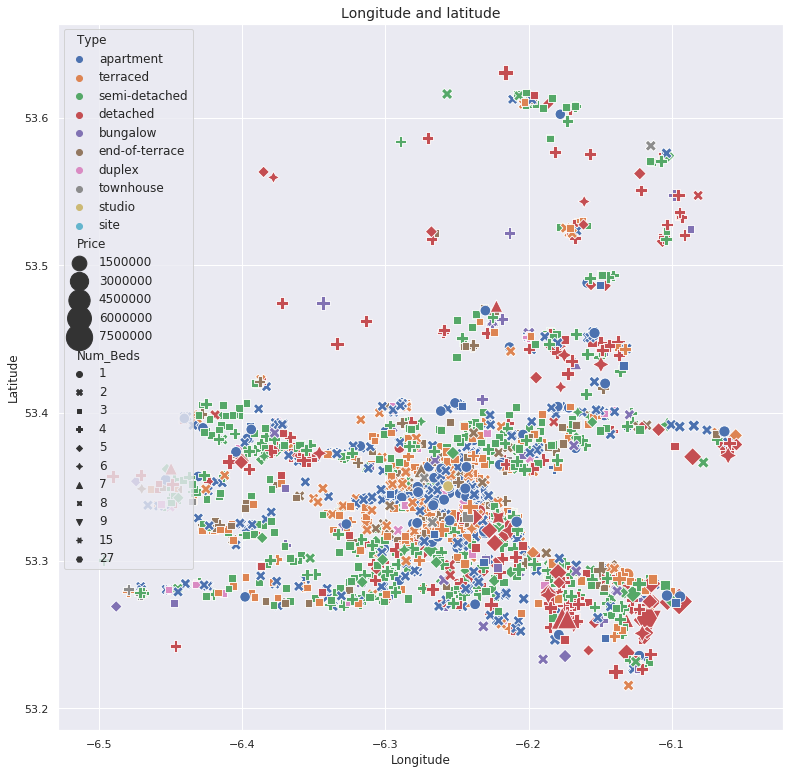

In [112]:
sns.set(rc={'figure.figsize':(13,13)})

sns.scatterplot(data=df_train_clean,
                x='Longitude',
                y='Latitude',
                style='Num_Beds',
                size="Price",
                hue="Type",
                sizes=(100, 800))

plt.title("Longitude and latitude", fontsize=14)
plt.show()

#### Continue with the preperation <a id='continue_cleaning'></a>
Convert `BER_class` into numerical formats. I think the increasing number in `BER_class` is justified as that what the classification is - I.E an increasing number means it uses more energy.

In [113]:
# Replace all ber values with equivalant decimal values. Last value is 'nan' so ignore that
df_train_clean.dropna(subset=['BER_class'], inplace=True)
ber_features = df_train_clean['BER_class'].sort_values().unique()

new_ber_values = np.arange(1, len(ber_features) + 1).tolist()

df_train_clean['BER_class'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)

df_test_clean.dropna(subset=['BER_class'], inplace=True)
df_test_clean['BER_class'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)

In [114]:
# Replace property type
replace_ptype_features = ['apartment', 'studio', 'duplex', 'townhouse', 'terraced', 'end-of-terrace',
                          'semi-detached', 'detached', 'bungalow', 'site' ]

replace_values = np.arange(1, len(replace_ptype_features) + 1).tolist()

# Apply basic conversion to the property type
df_train_clean['Type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)

df_test_clean['Type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)
                
# Remove columns with 0 - causes problems for the scalers used below
df_train_new = df_train_clean[(df_train_clean.Num_Beds>0)]

# Also drops all sites - this is intended
df_train_new = df_train_clean[(df_train_clean.Num_Bathrooms>0)]

df_train_new = df_train_clean[(df_train_clean.Price>0)]

#### Look again at the cleaned data.

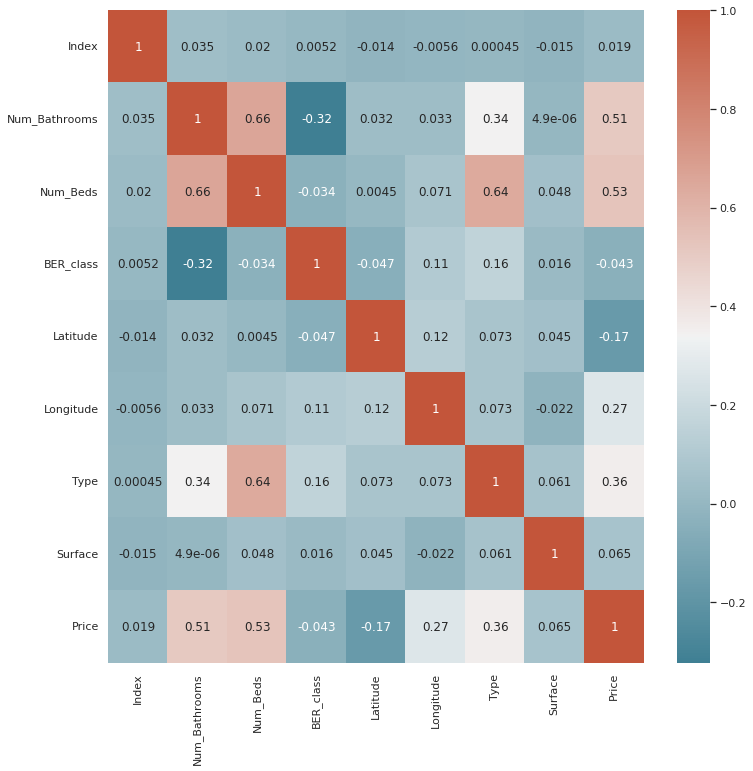

In [115]:
create_heat_map(df_train_clean)

In [116]:
print("Cleaned training missing values")
df_train_clean.isna().sum()

Cleaned training missing values


Index            0
Location         0
Num_Bathrooms    0
Num_Beds         0
BER_class        0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
Price            0
dtype: int64

In [117]:
df_train_clean.describe(include='all')

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Type,Surface,Price
count,1387.000000,1387,1387.000000,1387.000000,1387.000000,1387,1387,1387.000000,1387.000000,1387.000000,1387.000000,1.387000e+03
unique,NaN,137,NaN,NaN,NaN,1387,998,NaN,NaN,NaN,NaN,NaN
top,NaN,Castleknock,NaN,NaN,NaN,DNG are delighted to present to the market no....,None,NaN,NaN,NaN,NaN,NaN
freq,NaN,53,NaN,NaN,NaN,1,388,NaN,NaN,NaN,NaN,NaN
mean,823.229993,NaN,2.045422,3.031002,9.897621,NaN,NaN,53.349563,-6.254741,5.098053,176.248536,5.421249e+05
std,470.617527,NaN,1.127557,1.190895,3.101862,NaN,NaN,0.074343,0.091399,2.714488,1946.329376,4.587390e+05
min,1.000000,NaN,1.000000,1.000000,1.000000,NaN,NaN,53.215381,-6.497000,1.000000,22.450000,1.000000e+05
25%,420.500000,NaN,1.000000,2.000000,8.000000,NaN,NaN,53.292078,-6.304369,1.000000,74.100000,3.000000e+05
50%,826.000000,NaN,2.000000,3.000000,10.000000,NaN,NaN,53.340399,-6.244568,6.000000,98.300000,4.150000e+05
75%,1225.000000,NaN,3.000000,4.000000,12.000000,NaN,NaN,53.380564,-6.188047,7.000000,136.505000,5.999500e+05


In [118]:
print("Cleaned testing missing values")
df_test_clean.isna().sum()

Cleaned testing missing values


Index            0
Location         0
Num_Bathrooms    0
Num_Beds         0
BER_class        0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
dtype: int64

Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Features', 'Latitude', 'Longitude', 'Type', 'Surface',
       'Price'],
      dtype='object')


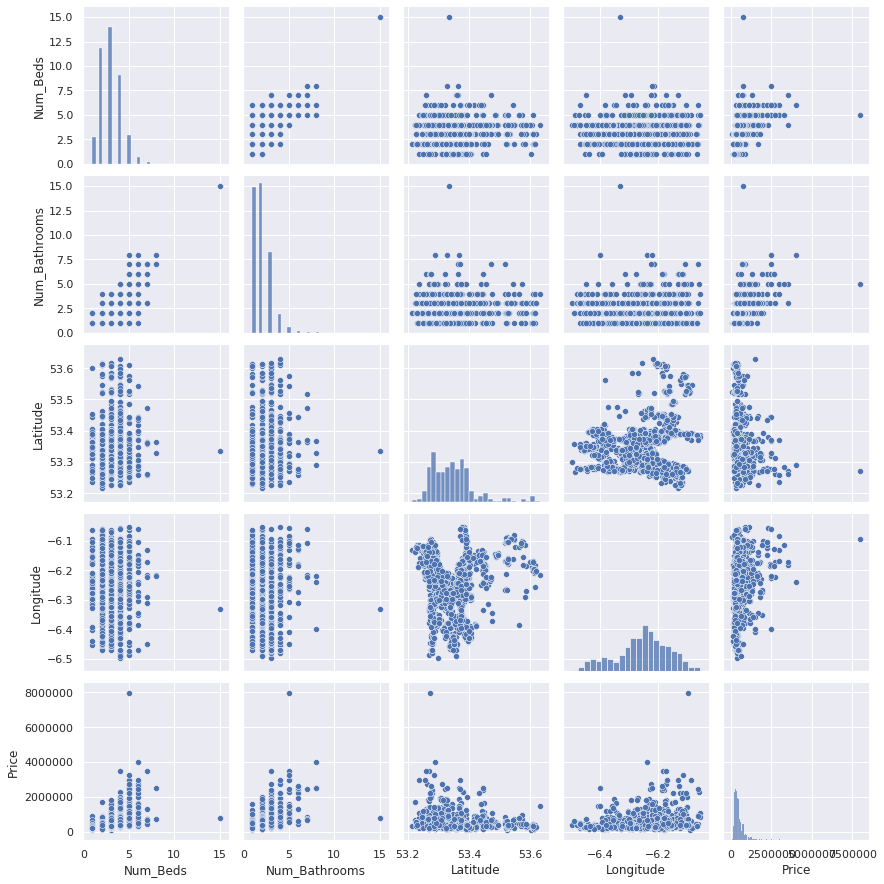

In [119]:
print(df_train_clean.columns)
sns.pairplot(data=df_train_clean[['Num_Beds','Num_Bathrooms', 'Latitude', 'Longitude', 'Price']])

# NATURAL LANGUAGE PROCESSING <a id='nlp_processing'></a>

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Now apply some NLP examination to the `Description` and `Features` attributes.

* Clean up the text data by:
    * Remove words less than 4 in length (the, as etc). They are too common and probably don't add value
    * Convert all to lowercase
* Then tokenise the data - split into smallest parts
* Then add back into a dataframe for processing.

Other options include
* Lemmatize the data - more advanced form of stemming (reducing a word to its base/root)
* Get n-grams - group of n words that commonly appear together in a text.
* Visualise
* Review and repeat

### NLK
Using NLK to initially implement the above

In [127]:
# Initialise a stemmer - reduce a word to its base/root. Could try to find a similar method for lemmatisation
stemmer = SnowballStemmer('english', ignore_stopwords=False)

In [128]:
stop_words = set(stopwords.words('english'))

In [129]:
# Removing `BER_class` as I have converted that separately above
text_features = ['Location', 'Description', 'Features']#, 'Type']

Perform some pre-processing mentioned above on training and test data.

In [130]:
df_train_nlp = nlk_nlp_preprocess(text_features, stop_words, df_train_clean, 4)

Len of feat 1387
Len of feat 1387
Len of feat 1387


In [131]:
# TODO Need to check the size of this vs expected 594 vs 1387...
print(df_test_clean.shape)
df_test_nlp = nlk_nlp_preprocess(text_features, stop_words, df_test_clean, 4)

(594, 11)
Len of feat 594
Len of feat 594
Len of feat 594


Lets see what the data now looks like

In [132]:
df_train_nlp.head()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Type,Surface,Price
0,1,ongar,2,2,9,delighted present market chipping bedroom apar...,,53.396659,-6.438791,1,67.00,195000
1,2,north strand,1,2,10,northbrook terrace charming brick period seclu...,bight spacious interior numerous original feat...,53.357129,-6.239779,5,95.97,425000
2,3,stepaside,3,3,3,welcome cotter close immaculately presented th...,special features large garden generous street ...,53.266468,-6.222771,7,107.00,535000
3,4,cabinteely,1,3,12,welcome sycamore enjoying premier address smal...,wonderful detached bungalow accommodation exte...,53.261600,-6.166738,8,81.00,499000
4,5,,3,4,10,seasons comes market wonderful opportunity see...,detached property double glazed windows double...,53.550731,-6.121415,8,153.00,510000


In [133]:
df_test_nlp.head()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Type,Surface
0,1639,milltown,2,2,8,estate agents delighted present townhouse situ...,designated parking spaces presented pristine c...,53.316269,-6.243391,4,65.0
1,1640,glasnevin,2,5,12,welcome saint anthony glasnevin avenue substan...,modern worcester boiler single glazed windows ...,53.390769,-6.281936,7,142.0
2,1641,dalkey,1,2,15,located popular grounds approximately killiney...,bedroom detached house fired central heating s...,53.272486,-6.108675,8,80.0
3,1642,raheny,4,4,2,delighted represent impeccable tyler owens des...,detached house south facing garden street park...,53.376932,-6.185334,8,209.0
4,1643,crumlin,2,3,14,unique opportunity acquire brick bedroom prope...,brick terrace property facing garden garage la...,53.327208,-6.308938,6,108.0


### Splitting the data
Since there is no `Price` in the test data, I have to use the training data, so I will split that into training and test datasets.

In [134]:

# Seperating the predictor variable from the data set
X_data = df_train_nlp.loc[:, df_train_nlp.columns != 'Price']
y_data = df_train_nlp['Price']

#print(df_train_nlp.columns)
#print(X_data.columns)
#print(y_data)

In [135]:
# Try 75/25 split for now
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.25)

In [136]:
print(X_train.columns)
print(type(X_train))
print(y_train)
print(type(y_train))

Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Features', 'Latitude', 'Longitude', 'Type', 'Surface'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
639      350000
660      239000
650      595000
1204     245000
875      310000
         ...   
143      445000
306      350000
566      215000
384      529950
49      2000000
Name: Price, Length: 1040, dtype: int64
<class 'pandas.core.series.Series'>


TfidfVectorizer - Convert a collection of raw documents to a matrix of **T**erm **F**requency-**I**nverse **D**ocument **F**requency features.
* How relevant a word is to a document in a collection of documents.

In [137]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= 300, max_df=0.5, smooth_idf=True)
print(vectorizer)

TfidfVectorizer(max_df=0.5, max_features=300, stop_words='english')


TBC .. Do I need to combine the text features before doing this ? - the X and y values are producing errors here.... Reading the fit_transform(), it needs an iterable

In [138]:
# Learn vocabulary and idf, return document-term matrix. This would imply 1 item for all features.
X_loc = vectorizer.fit_transform(df_train_nlp['Location'])
X_loc.shape

(1387, 131)

In [139]:
y_loc = df_train_nlp['Location']
y_loc.shape

(1387,)

Combine over and under-sampling using SMOTE and Tomek.

In [ ]:
smk = SMOTETomek()

# Change from fit_sample() to fit_resample() due to error... fit_sample() deprecated in v 0.4 of sklearn ??
X_bal, y_bal = smk.fit_resample(X_loc, y_loc)

## Train the model

In [ ]:
# create a model
MNB = MultinomialNB()

# fit to data
MNB.fit(X_train, y_train)

In [ ]:
# Testing the model

prediction_train = MNB.predict(X_train)
print('training prediction\t', prediction_train)

prediction_test = MNB.predict(X_test)
print('test prediction\t\t', prediction_test)

## Accuracy
For the training set

In [ ]:
# accuracy in training set
y_pred_train = prediction_train
print("Train Accuracy: "+str(accuracy_score(y_train, y_pred_train)))

For the testing set.

In [ ]:
# accuracy in test set (unseen data)
y_true = y_test
y_pred_test = prediction_test
print("Test Accuracy: "+str(accuracy_score(y_true, y_pred_test)))

### SpaCy implementation
TBC ... Trying the same process with spaCy for learning...  From [AI-1](#AI-1) below, we:

In [ ]:
# Going to try with spaCy - load the English model
nlp = sp.load("en_core_web_sm")

# Create document container for the 'Description', 'Features' and 'Type'
desc_doc = nlp(np.array2string(df_train_clean['Description'].values))
feat_doc = nlp(np.array2string(df_train_clean['Features'].values))

Lets have a look at the data now, first the sentences and then some tokens

In [ ]:
for sent in desc_doc.sents:
    print("One {}".format(sent))

In [ ]:
print(list(desc_doc.sents)[0][2].text)
print(list(desc_doc.sents)[0][2].head)
print(list(desc_doc.sents)[0][2].ent_type)
print(list(desc_doc.sents)[0][2].lemma_)

In [ ]:
sentence1 = list(desc_doc.sents)[0]
sp.displacy.render(sentence1, style="dep")

TBC ... Shouldn't be removing digits from the description/features like in the spam example. Might need that info.

### NLP Expected Cost dataset
The expected output for submission to kaggle is a CSV with Index,Price as the only 2 columns.

In [ ]:
# Generate descriptive statistics
#dfcost.describe()

# PIECEWISE REGRESSION <a id='piecewise_regression'></a>

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

For now, until I get more from the NLP, I will drop the 3 textual features listed above to get base from which to start/measure from. All other features at this stage should be converted or dropped.

In [142]:
drop_features = ['Index', 'Description', 'Features']
df_train_clean = df_train_clean.drop(columns=drop_features)

# Drop same columns from the test data set
df_test_clean = df_test_clean.drop(columns=drop_features)

#### Using RandomForest for feature importance selection
Suggestion from Carlos from etivity2

Features left in dataset
 ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude', 'Longitude', 'Type', 'Surface', 'Price']


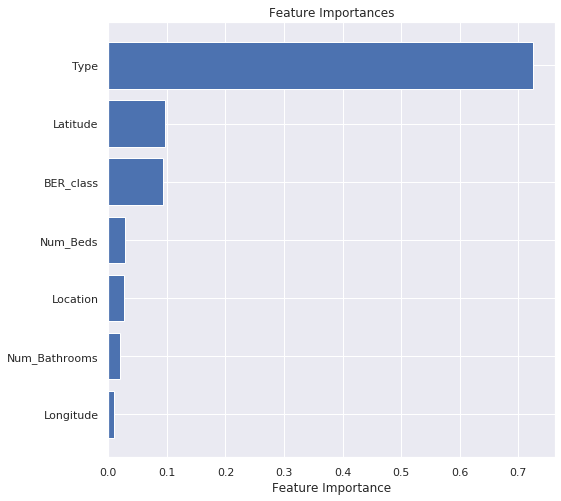

In [143]:
print("Features left in dataset\n {}".format(list(df_train_clean.columns.values)))

# Drop location as need numerical values
tmp_data = df_train_clean.drop('Location', axis=1).values
num_rows, num_cols = tmp_data.shape

model = RandomForestRegressor(random_state=8, max_depth=8)
X_orig = tmp_data[:,0:(num_cols -1)]
y_orig = tmp_data[:,(num_cols - 1)]
      
model.fit(X_orig, y_orig)

features = df_train_clean.drop('Price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

sns.set(rc={'figure.figsize':(8,8)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')#, width=1)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

#### Using ExtraTreesClassifier for feature importance selection
Using this as another method to compare to the above - a second opinion.

[0.05313668 0.05682033 0.15528803 0.22248368 0.22074989 0.06905876
 0.22246264]


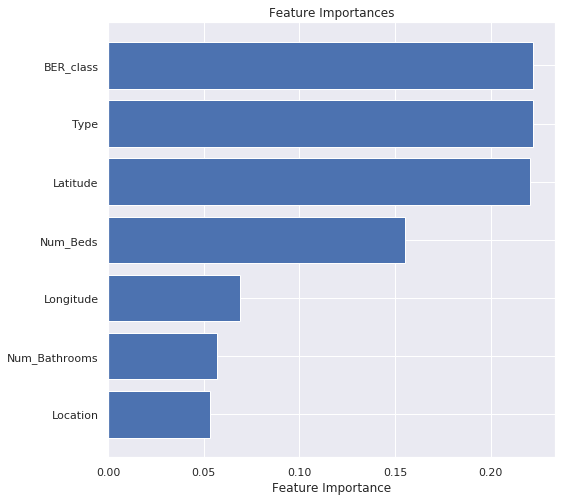

In [144]:
extra_tmp_data = df_train_clean.drop('Location', axis=1).values
num_rows, num_cols = extra_tmp_data.shape

X_orig = extra_tmp_data[:,0:(num_cols -1)]
y_orig = extra_tmp_data[:,(num_cols - 1)]

model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_orig, y_orig)

print(model.feature_importances_)
features = df_train_clean.drop('Price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

sns.set(rc={'figure.figsize':(8,8)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

## Apply a full model <a id='apply_full_model'></a>
Now apply all of the features you are going to use to see how they perform together. We have been given 3 datasets, including 1 training and 1 testing, so I don't see the need to split the training set like others are doing.

In [145]:
# Select some features columns just for the baseline model

featrain = ['Num_Beds','Num_Bathrooms', 'Latitude','Longitude', 'BER_class', 'Price']

# dropna: remove missing values
df_subset_train = df_train_clean[featrain].dropna(axis=0)

# Test data
df_subset_test = df_test_clean[featrain[:-1]].dropna(axis=0)


In [146]:
print('Number of nan in df_subset_train dataset: ',df_subset_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',df_subset_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


Quick check on what we are going to use

In [147]:
df_subset_train.describe()

,Num_Beds,Num_Bathrooms,Latitude,Longitude,BER_class,Price
count,1387.000000,1387.000000,1387.000000,1387.000000,1387.000000,1.387000e+03
mean,3.031002,2.045422,53.349563,-6.254741,9.897621,5.421249e+05
std,1.190895,1.127557,0.074343,0.091399,3.101862,4.587390e+05
min,1.000000,1.000000,53.215381,-6.497000,1.000000,1.000000e+05
25%,2.000000,1.000000,53.292078,-6.304369,8.000000,3.000000e+05
50%,3.000000,2.000000,53.340399,-6.244568,10.000000,4.150000e+05
75%,4.000000,3.000000,53.380564,-6.188047,12.000000,5.999500e+05
max,15.000000,15.000000,53.630588,-6.054719,16.000000,7.950000e+06


In [148]:
df_subset_test.describe()

,Num_Beds,Num_Bathrooms,Latitude,Longitude,BER_class
count,594.000000,594.000000,594.000000,594.000000,594.000000
mean,3.026936,2.052189,53.348393,-6.247592,9.872054
std,1.181340,1.038372,0.074475,0.091060,3.231975
min,1.000000,1.000000,53.215264,-6.521183,2.000000
25%,2.000000,1.000000,53.292096,-6.299643,8.000000
50%,3.000000,2.000000,53.339526,-6.243266,10.000000
75%,4.000000,3.000000,53.380315,-6.179319,12.000000
max,14.000000,6.000000,53.617443,-6.057150,16.000000


In [149]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values

# train set, output column is price
ys_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:].values

# TODO Need to check the validity of doing this
# Since no separate test Prices, use prices from training data but there
# is no matching index between the testing set and training set
y_test = df_train_clean.Price[0:len(df_subset_test)].values

print(Xs_train.shape)
print(ys_train.shape)
print(Xs_test.shape)
print(y_test.shape)


(1387, 5)
(1387, 1)
(594, 5)
(594,)


Finished [100%]: Average Loss = 1,390.6


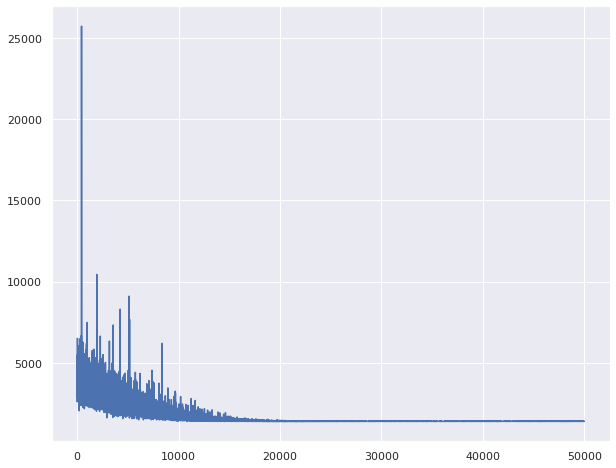

In [150]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

# hstack will concatenation along the second axis
Xss_train = np.hstack([Xs_train, Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test, Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))

yscaler = sc.fit(ylog)
yn_train = yscaler.transform(ylog)

full_posterior, full_approximation = run_model(Xn_train, yn_train, num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(full_approximation.hist);

In [151]:
# prediction
ll=np.mean(full_posterior['alpha']) + np.dot(np.mean(full_posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]

full_model_mae = np.mean(abs(y_pred_BLR - y_test))
full_model_mape = np.mean(abs(y_pred_BLR - y_test) / y_test)

print("Full model prediction")
print("MAE = {}".format(full_model_mae))
print("MAPE = {}".format(full_model_mape))

Full model prediction
MAE = 319602.63259907445
MAPE = 0.6653916823505905


## Clustering <a id='clustering'></a>
In this section we will break the full dataset into smaller clusters based on features to see if they can reduce the overall MAE value seen above.

### Full Model Cluster <a id='full_model_cluster'></a>

In [152]:
# Training gaussian mixture model. Must equal the number of features I chose
gmm = GaussianMixture(n_components=5)

# clustering by features long & lat
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind], Xn_test[:,ind]])

# Gaussian Mixture
gmm.fit(X_ind)

GaussianMixture(n_components=5)

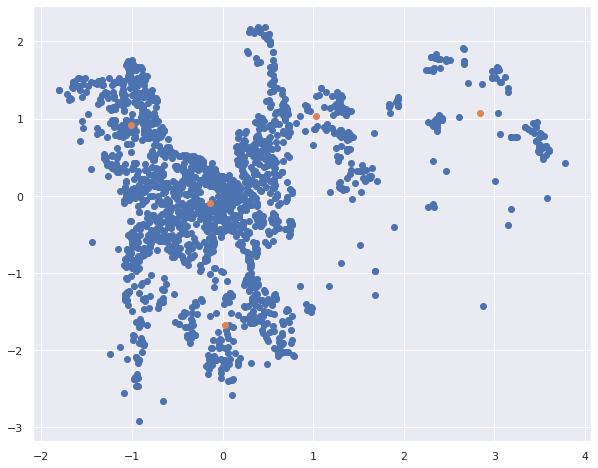

In [153]:
# plot blue dots
plt.figure(figsize=(10, 8))
plt.scatter(X_ind[:,0],X_ind[:,1])

# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [154]:
np.max(ys_train)

7950000

## Cluster setup <a id='cluster_setup'></a>
Now setup the training and testing clusters.

#### Training clusters

In [155]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

print("{} {}".format(unique_train, counts_train))

[0 1 2 3 4] [256 222 124  81 704]


#### Testing clusters

In [156]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

print("{} {}".format(unique_test, counts_test))

[0 1 2 3 4] [115  80  58  34 307]


## Simulations and Piecewise Model <a id='simulations'></a>

Running piecewise regression on a number of clusters to see if they produce a better outcome than the full single model above.

#### Cluster 0

Finished [100%]: Average Loss = 257.74


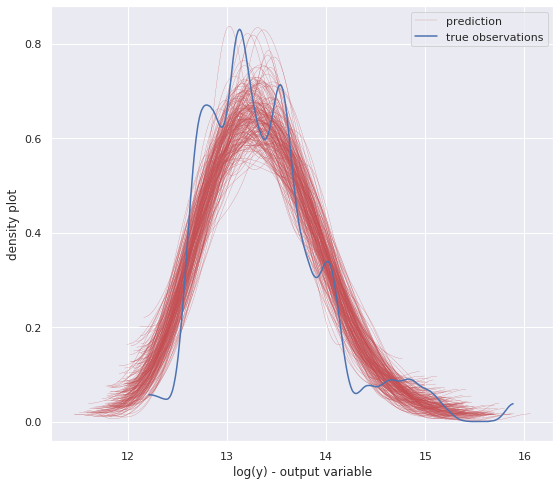

In [157]:
ylog0, yscaler, Xn0, yn0, Xtestn0, yscaler0 = train_cluster(Xn_train, Xn_test, 0)
cl0_posterior, cl0_approximation = run_model(Xn0, yn0, num_iter, sample_size)
cluster_sim(cl0_posterior, Xn0, ylog0, num_samples=num_of_clust_samples)

#### Cluster 1

Finished [100%]: Average Loss = 240.86


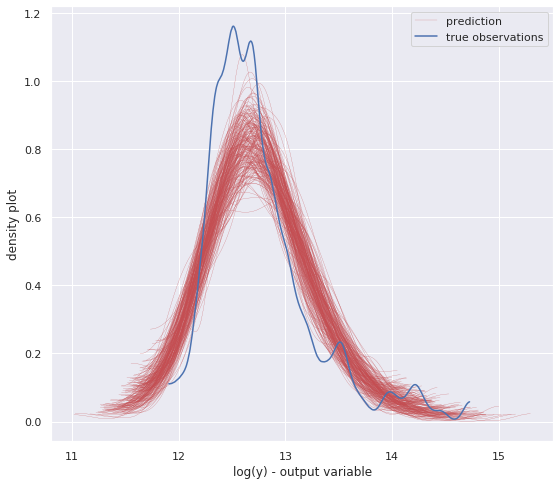

In [158]:
ylog1, yscaler, Xn1, yn1, Xtestn1, yscaler1 = train_cluster(Xn_train, Xn_test, 1)
cl1_posterior, cl1_approximation = run_model(Xn1, yn1, num_iter, sample_size)
cluster_sim(cl1_posterior, Xn1, ylog1, num_samples=num_of_clust_samples)

#### Cluster 2

Finished [100%]: Average Loss = 150.44


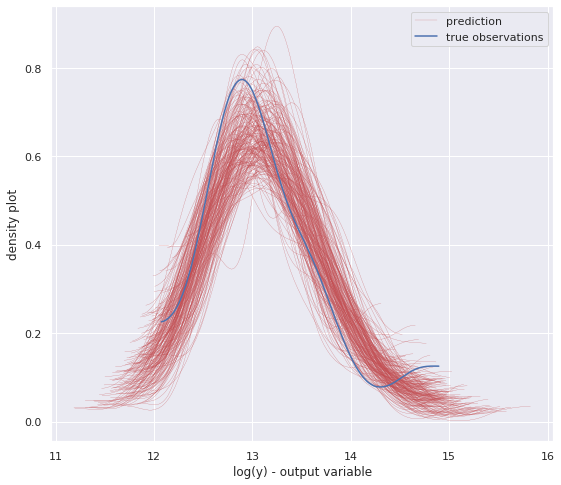

In [159]:
ylog2, yscaler, Xn2, yn2, Xtestn2, yscaler2 = train_cluster(Xn_train, Xn_test, 2)
cl2_posterior, cl2_approximation = run_model(Xn2, yn2, num_iter, sample_size)
cluster_sim(cl2_posterior, Xn2, ylog2, num_samples=num_of_clust_samples)

#### Cluster 3

Finished [100%]: Average Loss = 125.55


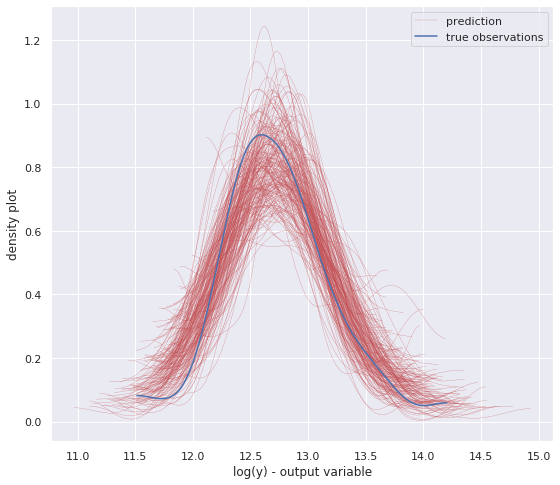

In [160]:
ylog3, yscaler, Xn3, yn3, Xtestn3, yscaler3 = train_cluster(Xn_train, Xn_test, 3)
cl3_posterior, cl3_approximation = run_model(Xn3, yn3, num_iter, sample_size)
cluster_sim(cl3_posterior, Xn3, ylog3, num_samples=num_of_clust_samples)

#### Cluster 4

Finished [100%]: Average Loss = 742.6


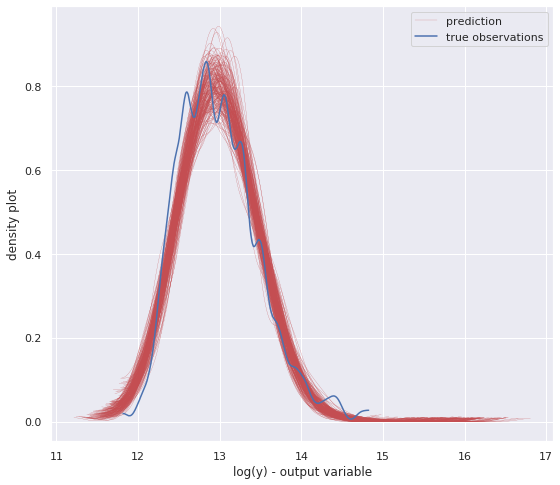

In [161]:
ylog4, yscaler, Xn4, yn4, Xtestn4, yscaler4 = train_cluster(Xn_train, Xn_test, 4)
cl4_posterior, cl4_approximation = run_model(Xn4, yn4, num_iter, sample_size)
cluster_sim(cl4_posterior, Xn4, ylog4, num_samples=num_of_clust_samples)

### Overall

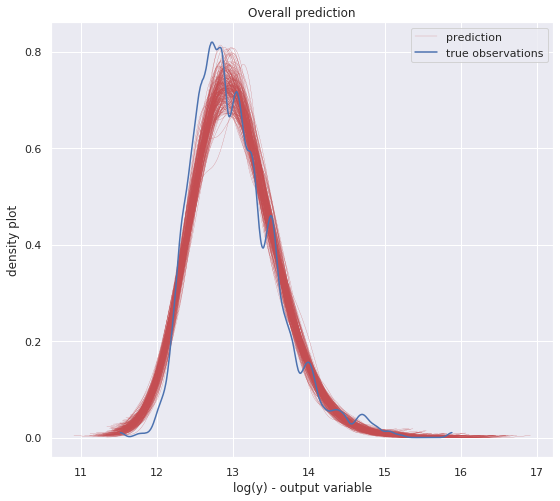

In [162]:
# posteriors
Ypred0 = ppc(cl0_posterior['alpha'],cl0_posterior['beta'],cl0_posterior['sigma_n'],
             Xn0, nsamples=num_of_clust_samples)
Ypred1 = ppc(cl1_posterior['alpha'],cl1_posterior['beta'],cl1_posterior['sigma_n'],
             Xn1, nsamples=num_of_clust_samples)
Ypred2 = ppc(cl2_posterior['alpha'],cl2_posterior['beta'],cl2_posterior['sigma_n'],
             Xn2, nsamples=num_of_clust_samples)
Ypred3 = ppc(cl3_posterior['alpha'],cl3_posterior['beta'],cl3_posterior['sigma_n'],
             Xn3, nsamples=num_of_clust_samples)
Ypred4 = ppc(cl4_posterior['alpha'],cl4_posterior['beta'],cl4_posterior['sigma_n'],
             Xn4, nsamples=num_of_clust_samples)

# simulation
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4) ])

ylog=np.vstack([ylog0, ylog1, ylog2, ylog3, ylog4])
plot_redictions(Ypred, ylog, "Overall prediction")


## Test set performance <a id='test_set_perf'></a>

In [ ]:
# TODO - Need to check the input here - 
print(Xtestn0.shape)
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(cl0_posterior['alpha']) 
              + np.dot(np.mean(cl0_posterior['beta'],axis=0), Xtestn0.T)))


In [ ]:
# Cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(cl0_posterior['alpha']) 
              + np.dot(np.mean(cl0_posterior['beta'],axis=0), Xtestn0.T)))

print("Cluster 0 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==0),
    (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))),
    (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]) /y_test[clusters_test==0])) ) )

# Cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(cl1_posterior['alpha']) 
              + np.dot(np.mean(cl1_posterior['beta'],axis=0), Xtestn1.T)))

print("Cluster 1 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==1),
    (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))),
    (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]) /y_test[clusters_test==1])) ) )

# Cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(cl2_posterior['alpha']) 
              + np.dot(np.mean(cl2_posterior['beta'],axis=0), Xtestn2.T)))

print("Cluster 2 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==2),
    (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))),
    (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]) /y_test[clusters_test==2])) ) )

# Cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(cl3_posterior['alpha']) 
              + np.dot(np.mean(cl3_posterior['beta'],axis=0), Xtestn3.T)))

print("Cluster 3 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==3),
    (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))),
    (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]) /y_test[clusters_test==3])) ) )

# Cluster 4
y_pred_BLR4 = np.exp(yscaler4.inverse_transform(np.mean(cl4_posterior['alpha']) 
              + np.dot(np.mean(cl4_posterior['beta'],axis=0), Xtestn4.T)))

print("Cluster 4 size is {} MAE = {}\tMAPE = {}".format(np.sum(clusters_test==4),
    (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]))),
    (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]) /y_test[clusters_test==4])) ) )


# Combined MAE
joint_mae = np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3]),
                 abs(y_pred_BLR4 - y_test[clusters_test==4]) ] )

# Combined MAPE
joint_mape = np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]) / y_test[clusters_test==0],
                 abs(y_pred_BLR1 - y_test[clusters_test==1]) / y_test[clusters_test==1],
                 abs(y_pred_BLR2 - y_test[clusters_test==2]) / y_test[clusters_test==2],
                 abs(y_pred_BLR3 - y_test[clusters_test==3]) / y_test[clusters_test==3],
                 abs(y_pred_BLR4 - y_test[clusters_test==4]) / y_test[clusters_test==4] ])

print("Full Regression Model MAE = {}".format(full_model_mae))
print("Full Regression Model MAPE = {}\n".format(full_model_mape))
print("Single Piecewise Regression Model MAE = {}".format(np.mean(joint_mae)))
print("Single Piecewise Regression Model MAPE = {}\n".format(np.mean(joint_mape)))

# BAYESIAN NN <a id='bayesian_nn'></a>

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

BNN's are Stochastic artificial neural networks trained using Bayesian methods. A stochastic NN is built by introducing randon variables into the network. This is generally done by using random activation functions or weights. This will allow you to simulate multiple possible models, so you can get a group (ensemble) of outcomes/learning. The reason for simulating multiple models is to be able to combine the predictions of the various models instead of 1 possibly better predicting model.
The main goal of SNN is to get a better idea of the uncertainty.

In [ ]:
# your code here

# SUMMARY

### Basic understanding

#### General
For the [nlp_processing](#nlp_processing) section, I ...
In [piecewise_regression](#piecewise_regression) I...
For the [bayesian_nn](#bayesian_nn) section I...

#### Peer Contribution

### References
#### Websites
<a id='AI-1'></a>https://becominghuman.ai/nlp-with-real-estate-advertisements-part-2-f944e566644b<br>
<a id='AI-2'></a>https://becominghuman.ai/nlp-with-real-estate-advertisements-part-1-55200e0cb33c<br>
http://spacy.pythonhumanities.com/01_02_linguistic_annotations.html
https://www.einfochips.com/blog/nlp-text-vectorization/

#### Books/Papers
* Laurent Valentin Jospin, Hamid Laga, Farid Boussaid, Wray Buntine, Mohammed Bennamoun, "Hands-on Bayesian Neural Networks – a Tutorial for Deep Learning Users" September 2021 https://arxiv.org/pdf/2007.06823.pdf